# Static Normalization (Standardization)

1. Get the per-feature statistics of the entire training data.
2. Apply the consistent normalization to the trining data during the training based on the statistics.
3. Apply the same normalization to the test data.

* [Data Preprocessing](https://cs231n.github.io/neural-networks-2/)

> Normalization refers to normalizing the data dimensions so that they are of approximately the same scale. There are two common ways of achieving this normalization. One is to divide each dimension by its standard deviation, once it has been zero-centered: ```(X /= np.std(X, axis = 0))```.

* [tf.keras.layers.Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

> This layer will **shift and scale inputs into a distribution centered around 0 with standard deviation 1**. It accomplishes this by precomputing the mean and variance of the data, and calling ```(input - mean) / sqrt(var) ``` at runtime.
>  
> **The mean and variance values for the layer must be either supplied on construction or learned via adapt()**. adapt() will compute the mean and variance of the data and store them as the layer's weights. adapt() should be called before fit(), evaluate(), or predict().

## Approaches

There are a few approaches for normalization.

### Regard every pixel is alike

In case of images, the relative scales of pixels are already approximately equal (and in range from 0 to 255). Hence divide all the data by 255.

```X = X / 255.0```

### Per channel

* [Channel-wise image normalization and interpolation with TensorFlow](https://dlhr.de/9)

> An image is comprised of matrices of pixel values that can be represented as tf.Tensor. It’s not recommended to present the raw 8-bit or 16-bit integer tensors to a CNN as it may fail to converge. This post demonstrates how a 16-bit RGB image tensor that is not using its full value range can be normalized to a float64 tensor that is interpolated channel-wise to use the full [0,1] range.

### Every pixel is a distinct feature

If there is (32x32) image, each index=(row,col) can be regarded as a feature. Then, extract every index, e.g. (row=3, col=3) from the entire images, which results in an array of shape (N, 3) where N is number of training images, 3 is (R, G, B). Then reshape it to (3N,) and calculate the statistics of the index=(row, col).

```
normalization = tf.keras.layer.Normalization(
    input_shape=input_shape,     # (32, 32, 3)
    axis=-1                      # Regard each pixel as a feature
)
normalization.adopt(X_train)
```


## Keras Layer Input Shape

Because the preprocessing normalization layer is the first layer to take inputs, it requires ```input_shape```.

* [Keras input explanation: input_shape, units, batch_size, dim, etc](https://stackoverflow.com/a/44748370/4281353)

> Example: if you have 30 images of 50x50 pixels in RGB (3 channels), the shape of your input data is (30,50,50,3). 
> 
> Keras demands the input shape at the first layer only, and Keras ignores the first dimension of the input data, which is the batch size. Your model should be able to deal with any batch size, so you define only the other dimensions:
> ```
> #regardless of how many images I have, each image has this shape   
> input_shape = (50,50,3)
> ```

---

## References

* [CS231n Data Preprocessing](https://cs231n.github.io/neural-networks-2/)
* [Keras input explanation: input_shape, units, batch_size, dim, etc](https://stackoverflow.com/a/44748370/4281353)
* [Keras - Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)
* [How to use tf.keras.layers.Normalization for more than one feature inside the model](https://stackoverflow.com/a/72756099/4281353)

## Note

DO NOT confuse the **preprocessing** layers with **those normalizations between layers** such as Batch Normalization which is applied to the logit output from a layer. 

* [Normalizations](https://www.tensorflow.org/addons/tutorials/layers_normalizations)

> This notebook gives a brief introduction into the normalization layers of TensorFlow. Currently supported layers are:
> 
> * Group Normalization (TensorFlow Addons)
> * Instance Normalization (TensorFlow Addons)
> * Layer Normalization (TensorFlow Core)

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Layer,
    Dense, 
    Dropout, 
    Flatten, 
    Normalization,
    BatchNormalization,
    Activation,
    Conv2D, 
    MaxPooling2D,
)
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

TensorFlow version: 2.10.0
Eager execution is: True
Keras version: 2.10.0


# CIFAR-10
The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.



class_names = \[
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
\]


## CIFAR10 Utilities

In [8]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CHANNELS = 3

In [9]:
def plot_cifar10_image(image, width, height, channels):
    reshaped = image.reshape(width, height, channels)
    plt.figure(figsize=(1,1)),
    plt.imshow(reshaped, cmap=plt.cm.binary)
    plt.axis("off")
    
def plot_cifar10_images(instances, width=IMAGE_WIDTH, height=IMAGE_HEIGHT, channels=NUM_CHANNELS, images_per_row=5, **options):
    plt.figure(figsize=(6,6))

    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(width, height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((width, width * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

## Data

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [11]:
input_shape = x_train[0].shape
input_shape

(32, 32, 3)

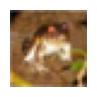

In [12]:
%matplotlib inline
plot_cifar10_image(x_train[0], IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)
plt.show()

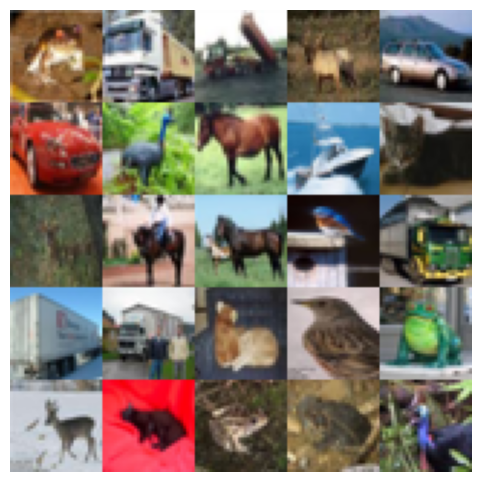

In [13]:
plot_cifar10_images(x_train[0:25], IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)

In [14]:
flatten = lambda l: [item for sublist in l for item in sublist]
number_of_classes = len(set(flatten(y_train)))
print("number_of_classes", number_of_classes)

number_of_classes 10


In [15]:
x_train, x_test = tf.cast(x_train, tf.float32), tf.cast(x_test, tf.float32)
y_train, y_test = tf.cast(y_train, tf.uint8), tf.cast(y_test, tf.uint8)
# x_train = x_train / 255.0
# x_test = x_test / 255.0

print(type(x_train))
print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print(y_train.dtype)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(50000, 32, 32, 3)
<dtype: 'float32'>
(50000, 1)
<dtype: 'uint8'>


# Training

## Data Normalization



In [11]:
normalization = Normalization(
    input_shape=input_shape,     # (32, 32, 3)
    axis=-1                      # Regard each pixel as a feature
)
normalization.adapt(x_train)

2023-02-15 13:32:10.097909: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Train
* C: Convolution layer
* P: Pooling layer
* B: Batch normalization layer
* F: Fully connected layer
* O: Output fully connected softmax layer

In [12]:
# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
if K.image_data_format() == 'channels_first':
    input_shape = (1, IMAGE_WIDTH, IMAGE_HEIGHT)
else:
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS,)

### Tensorboard callback

In [13]:
# tensorboard --logdir=/full_path_to_your_logs

import os
log_dir = os.getcwd() + os.path.sep + "logs"
print(log_dir)

/Users/oonisim/home/repository/git/oonisim/python-programs/tensorflow/tensorboard/logs


In [14]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    write_graph=True,
    write_images=True,
    histogram_freq=1,  # How often to log histogram visualizations
    embeddings_freq=1,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

### Early stop callback

In [15]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

### Trainer

In [16]:
batch_size = 300
number_of_epochs = 5
validation_split = 0.2
verbosity = 1
use_multiprocessing = True
workers = 4

l2_loss_lambda = 0.010
kernel_regularizer = regularizers.l2(l2_loss_lambda)

def train(model, x, y):
    model.compile(
        optimizer='adam', 
        loss=tf.keras.losses.sparse_categorical_crossentropy, 
        metrics=['accuracy']
    )
    history = model.fit(
        x, 
        y,
        shuffle=True,
        batch_size=batch_size,
        epochs=number_of_epochs,
        validation_split=validation_split,
        use_multiprocessing=use_multiprocessing,
        workers=workers,
        verbose=verbosity,
        callbacks=[
            tensorboard_callback,
            earlystop_callback
        ]
    )
    return(history)

### Train CPBFO model  (F/ReLU/He)

In [17]:
activation_function = lambda x: tf.keras.activations.relu(x, alpha=0.1, max_value=None, threshold=0.0)

In [18]:
model = Sequential([
    #normalization,
    BatchNormalization(
        name="input_normalization"
    ),
    Conv2D(
        name="conv01",
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        #activation='relu', 
        input_shape=input_shape
    ),
    Activation(activation=activation_function),
    MaxPooling2D(
        name="pool01",
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(
        name="batch_before_full01"
    ),
    Dense(
        name="full01", 
        units=300, 
        activation="relu"
    ),     # Fully connected layer 
    Dense(
        name="output_softmax", 
        units=number_of_classes, 
        activation="softmax"
    )
])

history = train(model, x_train, y_train)
print(history)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Epoch 1/5
134/134 [==============================] - 21s 150ms/step - loss: 1.8851 - accuracy: 0.4922 - val_loss: 1.5704 - val_accuracy: 0.4647
Epoch 2/5
134/134 [==============================] - 23s 175ms/step - loss: 0.9103 - accuracy: 0.6919 - val_loss: 1.2367 - val_accuracy: 0.5815
Epoch 3/5
134/134 [==============================] - 22s 164ms/step - loss: 0.5487 - accuracy: 0.8091 - val_loss: 1.1068 - val_accuracy: 0.6142
Epoch 4/5
134/134 [==============================] - 22s 168ms/step - loss: 0.3487 - accuracy: 0.8852 - val_loss: 1.1319 - val_accuracy: 0.6389
Epoch 5/5
100/100 [==============================] - 1s 11ms/step - loss: 1.2441 - accuracy: 0.6492
test loss, test accuracy: [1.2441129684448242, 0.6492000222206116]


# History

In [19]:
%load_ext tensorboard
%tensorboard --logdir $log_dir